**Transfer learning can  be done in two ways : 1. Feature extraction and 2.Fine Tuning**

**Feature Extraction without data augmentation**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/dogs-vs-cats.zip' mode='r'>>

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Dropout
from keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150,150,3)
)

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
conv_base.trainable = False

In [10]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [11]:
def process(image,label):
    image = tf.cast(image/255.,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [12]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [13]:
history = model.fit(train_ds,epochs=10,validation_data = validation_ds)

Epoch 1/10
625/625 [==============================] - 71s 104ms/step - loss: 0.2747 - accuracy: 0.8843 - val_loss: 0.2150 - val_accuracy: 0.9090
Epoch 2/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1967 - accuracy: 0.9161 - val_loss: 0.2298 - val_accuracy: 0.9032
Epoch 3/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1595 - accuracy: 0.9351 - val_loss: 0.2084 - val_accuracy: 0.9154
Epoch 4/10
625/625 [==============================] - 66s 104ms/step - loss: 0.1311 - accuracy: 0.9470 - val_loss: 0.2318 - val_accuracy: 0.9154
Epoch 5/10
625/625 [==============================] - 56s 89ms/step - loss: 0.1022 - accuracy: 0.9606 - val_loss: 0.2294 - val_accuracy: 0.9168
Epoch 6/10
625/625 [==============================] - 67s 107ms/step - loss: 0.0879 - accuracy: 0.9657 - val_loss: 0.2834 - val_accuracy: 0.9042
Epoch 7/10
625/625 [==============================] - 56s 89ms/step - loss: 0.0641 - accuracy: 0.9758 - val_loss: 0.3299 - val_accu

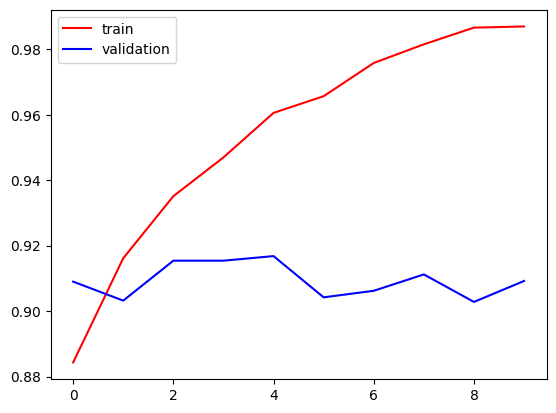

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

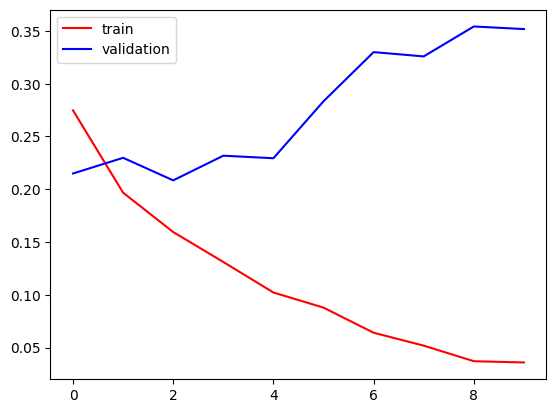

In [15]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

**Feature Extraction with data augmentation**

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img

batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(150,150),
    batch_size = batch_size,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(150,150),
    batch_size = batch_size,
    class_mode = 'binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [17]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [18]:
history = model.fit(train_generator, epochs=10,validation_data=validation_generator)

Epoch 1/10
625/625 [==============================] - 162s 257ms/step - loss: 0.2138 - accuracy: 0.9124 - val_loss: 0.2315 - val_accuracy: 0.9010
Epoch 2/10
625/625 [==============================] - 160s 257ms/step - loss: 0.1831 - accuracy: 0.9236 - val_loss: 0.2272 - val_accuracy: 0.9110
Epoch 3/10
625/625 [==============================] - 161s 257ms/step - loss: 0.1696 - accuracy: 0.9320 - val_loss: 0.2095 - val_accuracy: 0.9178
Epoch 4/10
625/625 [==============================] - 162s 259ms/step - loss: 0.1663 - accuracy: 0.9308 - val_loss: 0.1995 - val_accuracy: 0.9182
Epoch 5/10
625/625 [==============================] - 162s 259ms/step - loss: 0.1484 - accuracy: 0.9398 - val_loss: 0.2084 - val_accuracy: 0.9166
Epoch 6/10
625/625 [==============================] - 162s 260ms/step - loss: 0.1463 - accuracy: 0.9387 - val_loss: 0.2187 - val_accuracy: 0.9136
Epoch 7/10
625/625 [==============================] - 161s 257ms/step - loss: 0.1412 - accuracy: 0.9412 - val_loss: 0.2387 -

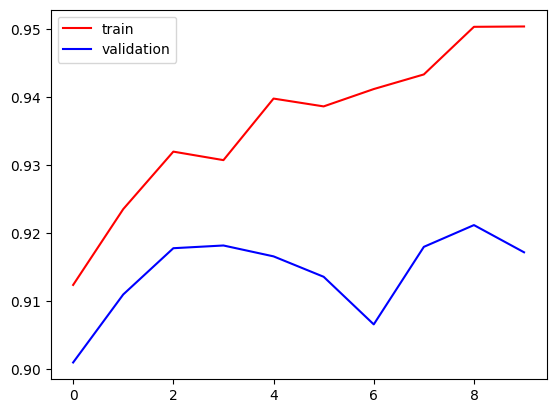

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

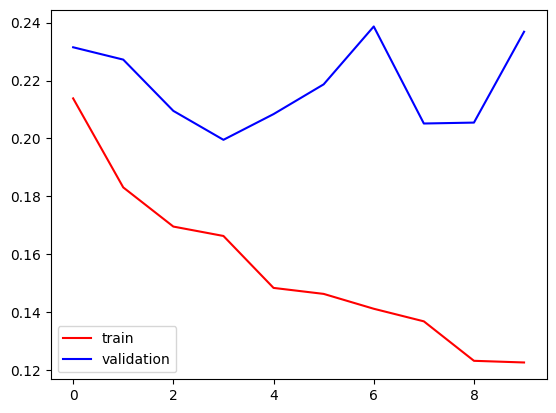

In [20]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

**Fine Tuning**



In [21]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
    print(layer,layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x79c751325b70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79c749430700> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79c749430e80> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79c7493bcfa0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79c74937fa60> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79c74937fd90> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79c749432b30> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79c749432f20> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79c749433fa0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79c749432c50> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79c748ab5390> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79c748ab5ab0> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

In [22]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [23]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [24]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [25]:
def process(image,label):
    image = tf.cast(image/255.,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [26]:
model.compile(optimizer = keras.optimizers.RMSprop(lr=1e-5),loss = 'binary_crossentropy',metrics = ['accuracy'])

In [27]:
history = model.fit(train_ds,epochs=10,validation_data = validation_ds)

Epoch 1/10
625/625 [==============================] - 67s 104ms/step - loss: 1.4431 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
625/625 [==============================] - 75s 119ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
625/625 [==============================] - 64s 102ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
625/625 [==============================] - 73s 117ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
625/625 [==============================] - 63s 101ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
625/625 [==============================] - 72s 115ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
625/625 [==============================] - 72s 115ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_ac